In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt

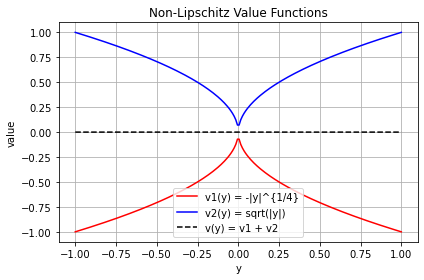

In [2]:
# 生成 y 值
y_vals = np.linspace(-1, 1, 200)
v1_list, v2_list, v_total_list = [], [], []

# 初始化求解器
solver = SolverFactory('ipopt')

for y in y_vals:
    # 场景1：v1(y) = -|y|^{1/4}
    model1 = ConcreteModel()
    model1.x1 = Var(bounds=(0, 1))
    model1.obj = Objective(expr=-model1.x1, sense=minimize)
    model1.eq = Constraint(expr=model1.x1**4 == y**2)
    
    try:
        result1 = solver.solve(model1, tee=False)
        v1 = value(model1.obj)
    except:
        v1 = np.nan

    # 场景2：v2(y) = sqrt(|y|)
    model2 = ConcreteModel()
    model2.x2 = Var(bounds=(0, 1))
    model2.obj = Objective(expr=model2.x2, sense=minimize)
    model2.con1 = Constraint(expr=model2.x2**2 >= y)
    model2.con2 = Constraint(expr=model2.x2**2 >= -y)
    
    try:
        result2 = solver.solve(model2, tee=False)
        v2 = value(model2.obj)
    except:
        v2 = np.nan

    # 合并记录
    v1_list.append(v1)
    v2_list.append(v2)
    if not np.isnan(v1) and not np.isnan(v2):
        v_total_list.append(v1 + v2)
    else:
        v_total_list.append(np.nan)

# 画图
plt.plot(y_vals, v1_list, label="v1(y) = -|y|^{1/4}", color='red')
plt.plot(y_vals, v2_list, label="v2(y) = sqrt(|y|)", color='blue')
plt.plot(y_vals, v_total_list, label="v(y) = v1 + v2", linestyle='--', color='black')
plt.title("Non-Lipschitz Value Functions")
plt.xlabel("y")
plt.ylabel("value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [21]:
modelas1 = ConcreteModel()

# 定义采样节点
breakpoints = [0.0, 0.25, 0.5, 0.75, 1.0]
values = [-z**0.5 for z in breakpoints]  # v1(z) = -sqrt(z)

# 定义变量
modelas1.z = Var(bounds=(0, 1))  # z = |y|
modelas1.as_approx = Var()       # piecewise approximation

# 设置 piecewise 关系
modelas1.pw = Piecewise(
    modelas1.as_approx, modelas1.z,
    pw_pts=breakpoints,
    pw_constr_type='EQ',
    f_rule=lambda m, z: -z**0.5,
    pw_repn='INC'  # 增量式表示
)

# 示例目标函数：最小化 as(z)
modelas1.obj = Objective(expr=modelas1.as_approx, sense=minimize)

# 运行求解器
solver = SolverFactory('ipopt')
solver.solve(modelas1, tee=True)

# 输出结果
print(f'z = {value(modelas1.z):.4f}')
print(f'a_s(z) = {value(modelas1.as_approx):.4f}')

Ipopt 3.14.17: 
==> Warning: Treating 3 binary and 0 integer variables as continuous.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        9
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        1
Total

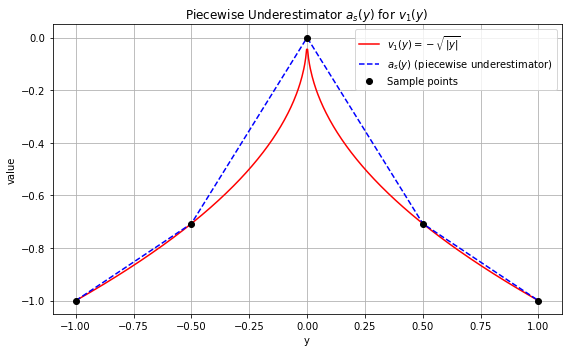

In [24]:
# 原函数 v1(y) = -sqrt(|y|)
def v1(y):
    return -np.sqrt(np.abs(y))

# 采样点（breakpoints）用于构造 piecewise 函数
y_nodes = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
z_nodes = np.abs(y_nodes)
as_nodes = -np.sqrt(z_nodes)  # 正确地为每个采样点计算函数值


# 定义细分 y 值（用于画图）
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# 构造 as(y)：z = |y|，在 z_nodes 上线性插值
as_vals = np.interp(z_vals, y_nodes, as_nodes)

# 原始函数 v1(y)
v1_vals = v1(y_vals)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(y_vals, v1_vals, label=r'$v_1(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, as_vals, label=r'$a_s(y)$ (piecewise underestimator)', color='blue', linestyle='--')
plt.scatter(y_nodes, as_nodes, color='black', zorder=5, label='Sample points')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Piecewise Underestimator $a_s(y)$ for $v_1(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# 采样点：构造 A_s(y)
y_nodes = [-1.0, -0.5, 0.0, 0.5, 1.0]
z_nodes = [1.0, 0.5, 0.0, 0.5, 1.0]
as_nodes = [-np.sqrt(z) for z in z_nodes]

# 创建模型
model = ConcreteModel()
model.x1 = Var(bounds=(0, 1))
model.y = Var(bounds=(-1, 1))
model.z = Var(bounds=(0, 1))  # z = |y|

# 表达 z = |y| 用两条不等式
model.abs1 = Constraint(expr=model.z >= model.y)
model.abs2 = Constraint(expr=model.z >= -model.y)

# piecewise 表达式 A_s(z)，正确写法：f_rule 需要两个参数
model.As = Var()
model.pw = Piecewise(
    model.As, model.z,
    pw_pts=y_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# 原始约束
model.eq = Constraint(expr=model.x1**4 == model.y**2)

# 目标函数
model.obj = Objective(expr= -model.x1 - model.As, sense=minimize)

# 求解
solver = SolverFactory('ipopt')
solver.solve(model)

# 输出结果
x1_opt = value(model.x1)
y_opt = value(model.y)
as_val = value(model.As)
m_s = -x1_opt - as_val

print(f"x1 = {x1_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s:.4f}")


ValueError: Cannot load a SolverResults object with bad status: error

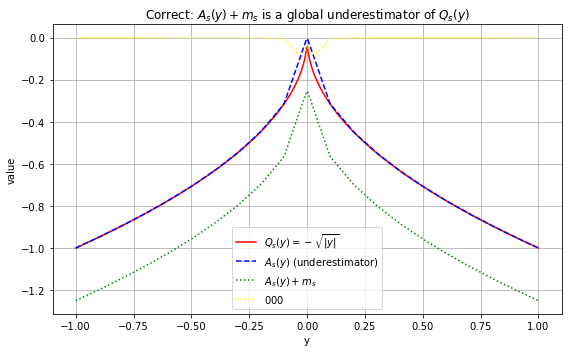

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# y 和 z = |y|
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# 原函数 Qs(y)
Qs_vals = -np.sqrt(z_vals)

# 下界 As(y)
z_nodes = np.array([0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0])
as_nodes = -np.sqrt(z_nodes)
As_vals = np.interp(z_vals, z_nodes, as_nodes)

# 正确的：As + ms 是 Qs 的下界
#m_s = -0.2
As_shifted_vals = As_vals + m_s  # 注意是 + ms，不是 - ms！

# 画图
plt.figure(figsize=(8, 5))
plt.plot(y_vals, Qs_vals, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.plot(y_vals, Qs_vals - As_vals, label=r'$000$', color='yellow', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# 采样点：构造 A_s(y)
z_nodes = [0.0, 0.5, 1.0]
as_nodes = [-np.sqrt(z) for z in z_nodes]

# 创建模型
model = ConcreteModel()
model.x1 = Var(bounds=(0, 1))
model.y = Var(bounds=(-1, 1))
model.z = Var(bounds=(0, 1))  # z = |y|

# 表达 z = |y| 用两条不等式
model.abs1 = Constraint(expr=model.z >= model.y)
model.abs2 = Constraint(expr=model.z >= -model.y)

# piecewise 表达式 A_s(z)，正确写法：f_rule 需要两个参数
model.As = Var()
model.pw = Piecewise(
    model.As, model.z,
    pw_pts=z_nodes,
    f_rule=as_nodes,
    pw_constr_type='EQ',
    pw_repn='INC'
)

# 原始约束
model.eq = Constraint(expr=model.x1**4 == model.y**2)

# 目标函数
model.obj = Objective(expr=  - model.As, sense=minimize)

# 求解
solver = SolverFactory('ipopt')
solver.solve(model)

# 输出结果
x1_opt = value(model.x1)
y_opt = value(model.y)
as_val = value(model.As)
m_s = -x1_opt - as_val

print(f"x1 = {x1_opt:.4f}, y = {y_opt:.4f}, A_s(y) = {as_val:.4f}, m_s = {m_s:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(z_nodes, as_nodes, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.plot(y_vals, Qs_vals - As_vals, label=r'$000$', color='yellow', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

x1 = 0.0001, y = 0.0000, A_s(y) = 0.0000, m_s = -0.0001


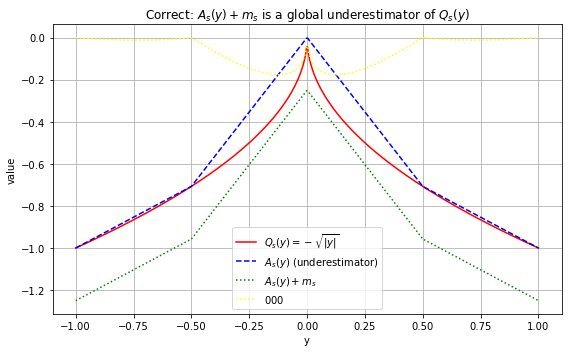

In [19]:
# y 和 z = |y|
y_vals = np.linspace(-1, 1, 500)
z_vals = np.abs(y_vals)

# 原函数 Qs(y)
Qs_vals = -np.sqrt(z_vals)

# 下界 As(y)
z_nodes = np.array([0.0, 0.5, 1.0])
as_nodes = -np.sqrt(z_nodes)
As_vals = np.interp(z_vals, z_nodes, as_nodes)

# 正确的：As + ms 是 Qs 的下界
#m_s = -0.2
As_shifted_vals = As_vals + m_s  # 注意是 + ms，不是 - ms！

# 画图
plt.figure(figsize=(8, 5))
plt.plot(z_nodes, as_nodes, label=r'$Q_s(y) = -\sqrt{|y|}$', color='red')
plt.plot(y_vals, As_vals, label=r'$A_s(y)$ (underestimator)', color='blue', linestyle='--')
plt.plot(y_vals, As_shifted_vals, label=r'$A_s(y) + m_s$', color='green', linestyle=':')
plt.plot(y_vals, Qs_vals - As_vals, label=r'$000$', color='yellow', linestyle=':')
plt.xlabel('y')
plt.ylabel('value')
plt.title('Correct: $A_s(y) + m_s$ is a global underestimator of $Q_s(y)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
conda install -c conda-forge coincbc scip


done
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::nbclassic==0.3.5=pyhd3eb1b0_0
  - defaults/osx-64::anaconda==2022.05=py39_0
  - defaults/noarch::jupyter_server==1.13.5=pyhd3eb1b0_0
  - defaults/osx-64::_ipyw_jlab_nb_ext_conf==0.1.0=py39hecd8cb5_1
  - defaults/noarch::jupyterlab_server==2.10.3=pyhd3eb1b0_1
  - defaults/noarch::jupyterlab==3.3.2=pyhd3eb1b0_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(538): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(538): Using .* with relational operator is superfluous and d

python_abi-3.9       | 4 KB      | ##################################### | 100% 
liblapack-3.9.0      | 12 KB     | ##################################### | 100% 
websocket-client-1.8 | 46 KB     | ##################################### | 100% 
openssl-1.1.1w       | 1.7 MB    | ##################################### | 100% 
ampl-mp-3.1.0        | 1.0 MB    | ##################################### | 100% 
libcblas-3.9.0       | 12 KB     | ##################################### | 100% 
ruamel.yaml.clib-0.2 | 119 KB    | ##################################### | 100% 
cctools-921          | 1.9 MB    | ##################################### | 100% 
cppad-20220000.1     | 433 KB    | ##################################### | 100% 
ca-certificates-2025 | 148 KB    | ##################################### | 100% 
hdf5-1.10.6          | 3.1 MB    | ##################################### | 100% 
mumps-include-5.2.1  | 25 KB     | ##################################### | 100% 
scipy-1.8.0          | 21.7 